Step 0, Loss: 18.7738094329834, Accuracy: 0.09375
Step 100, Loss: 18.61855697631836, Accuracy: 0.1015625
Step 200, Loss: 18.809764862060547, Accuracy: 0.09375
Step 300, Loss: 19.104259490966797, Accuracy: 0.078125
Step 400, Loss: 19.03472328186035, Accuracy: 0.078125
Step 500, Loss: 18.217140197753906, Accuracy: 0.12109375
Step 600, Loss: 18.137733459472656, Accuracy: 0.12890625
Step 700, Loss: 18.37570571899414, Accuracy: 0.11328125
Step 800, Loss: 19.185211181640625, Accuracy: 0.07421875
Step 900, Loss: 18.213836669921875, Accuracy: 0.12109375


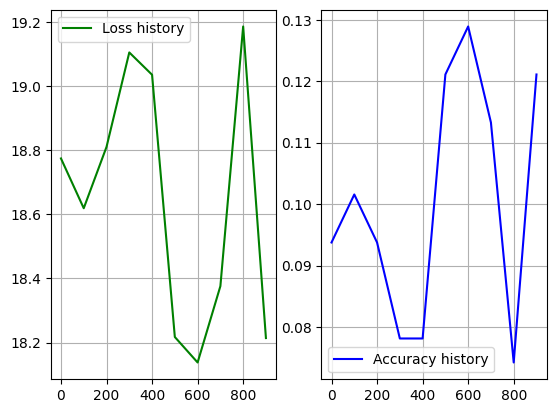

Accuracy on the test set: 0.11869999766349792


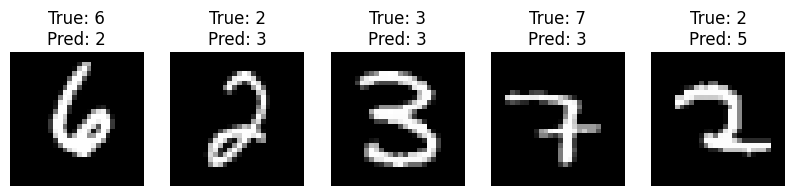

True label for sample 64: 7


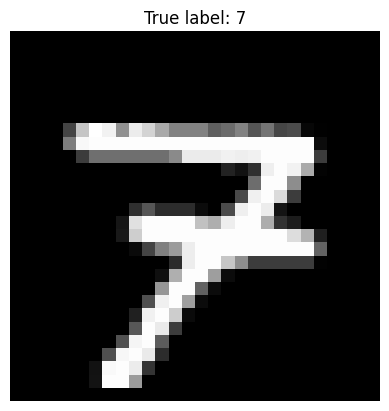

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.001
training_steps = 1000
batch_size = 256
display_step = 100
num_features = 784  # 28*28 pixels
num_classes = 10  # 0-9 digits
n_hidden_1 = 128  # Number of neurons in the first hidden layer
n_hidden_2 = 256  # Number of neurons in the second hidden layer

# Define Dense Layer class
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

# Define Neural Network class
class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        in_out = [num_features, n_hidden_1, n_hidden_2, num_classes]
        self.layers = [DenseLayer(in_out[i], in_out[i + 1], "layer") for i in range(len(in_out) - 1)]

    def __call__(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = tf.nn.relu(x)
        return tf.nn.softmax(x)

# Cross-entropy loss function
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Accuracy metric function
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    correct_predictions = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32)).numpy()

# Function to train the neural network
def train(nn, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = nn(input_x)
        loss = cross_entropy(pred, output_y)
        gradients = g.gradient(loss, nn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, nn.trainable_variables))
    return loss.numpy()

# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

# Instantiate neural network
neural_net = NN(name="mnist")

# Prepare the training dataset
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Training loop
loss_history = []
accuracy_history = []
display_steps = []

for step, (batch_x, batch_y) in zip(range(training_steps), train_data):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(loss)
        accuracy_history.append(accuracy(pred, batch_y))
        display_steps.append(step)
        print(f"Step {step}, Loss: {loss}, Accuracy: {accuracy(pred, batch_y)}")

# Plotting the loss and accuracy
if len(display_steps) == len(loss_history) == len(accuracy_history):
    plt.subplot(1, 2, 1)
    plt.plot(display_steps, loss_history, color='g')
    plt.grid(True)
    plt.legend(["Loss history"])
    
    plt.subplot(1, 2, 2)
    plt.plot(display_steps, accuracy_history, color='b')
    plt.grid(True)
    plt.legend(["Accuracy history"])
    
    plt.show()
else:
    print("Mismatch in the length of data lists. Check the training loop.")

# Calculate the accuracy on the test set
acc = accuracy(neural_net(x_test), y_test)
print(f"Accuracy on the test set: {acc}")

# Select 5 random images from the test set
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(x_test.shape[0], 5, replace=False)

plt.figure(figsize=(10, 5))

for i, idx in enumerate(random_indices):
    x_sample = x_test[idx].reshape(1, 784)
    y_sample = y_test[idx]
    
    # Predict the label using the neural network
    prediction = np.argmax(neural_net(x_sample), axis=1)
    
    # Plot the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_sample.reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_sample}\nPred: {prediction[0]}")
    plt.axis('off')

plt.show()

# Test a specific image
sample_num = 64
x1 = x_test[sample_num].reshape(28, 28)
print(f"True label for sample {sample_num}: {y_test[sample_num]}")
plt.imshow(x1, cmap='gray')
plt.title(f"True label: {y_test[sample_num]}")
plt.axis('off')
plt.show()
